In [1]:
import sys
import os
p = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(p, '..')))
sys.path

['/home/powell/work/insight/focal/notebooks',
 '/home/powell/work/insight/bablu/deps/models/research',
 '/home/powell/work/insight/bablu/deps/models/research/slim',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/powell/work/insight/insight/lib/python3.6/site-packages',
 '/home/powell/work/insight/insight/lib/python3.6/site-packages/mask_rcnn-2.1-py3.6.egg',
 '/home/powell/work/insight/insight/lib/python3.6/site-packages/pycocotools-2.0-py3.6-linux-x86_64.egg',
 '/home/powell/work/insight/insight/lib/python3.6/site-packages/IPython/extensions',
 '/home/powell/.ipython',
 '/home/powell/work/insight/focal']

In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.color
import skimage.io
import scipy.ndimage
import matplotlib
import matplotlib.pyplot as plt
import cv2
import datetime
import time
import pickle
import glob
from tqdm import tqdm

from joblib import Parallel, delayed

from skimage.transform import warp, AffineTransform

from utils.mrcnn_helper import show_images, resize_image
from data.indoor import get_image_paths
from data.portrait_indoor_aug import portrait_indoor_embed

%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

In [3]:
SCENE_DIR='/mnt/data/indoor/Images'
def show_rnd_scene_images(prefix, category, size=4):
    dir_prefix=os.path.join(prefix, category)
    file_names = random.sample(next(os.walk(dir_prefix))[2], size)
    images = [skimage.io.imread(os.path.join(dir_prefix, x)) for x in file_names]
    show_images(images, [category]*size)
    return images

def get_images_size(prefix, predicate_fn):
    output_list = []
    image_list = get_image_paths(prefix)
    images_loaded = [skimage.io.imread(os.path.join(prefix, x)) for x in image_list]
    images_loaded = [x for x in images_loaded if predicate_fn(x.shape[0], x.shape[1]) is True]
    return images_loaded                    

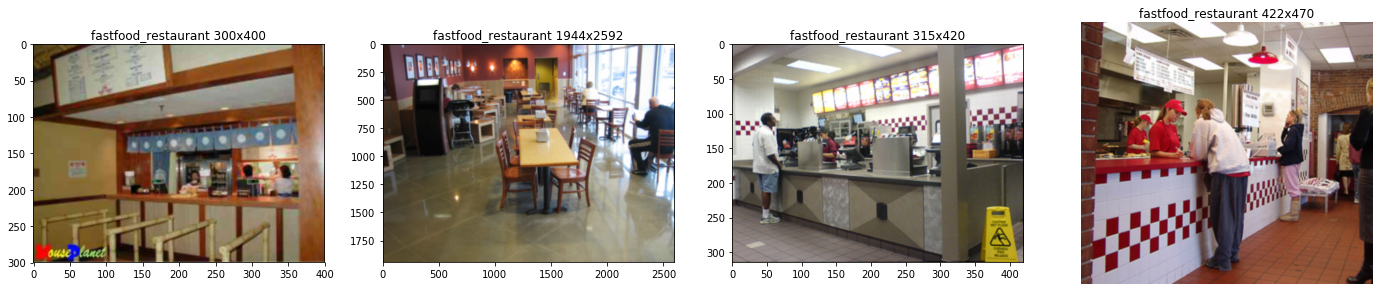

In [4]:
rnd_indoor_images = show_rnd_scene_images(prefix=SCENE_DIR, category='fastfood_restaurant')

In [5]:
indoor_images_size_list = get_images_size(prefix=SCENE_DIR, predicate_fn = lambda h,w: w < h and w < 600 and 800 - h < 600 - w)

84


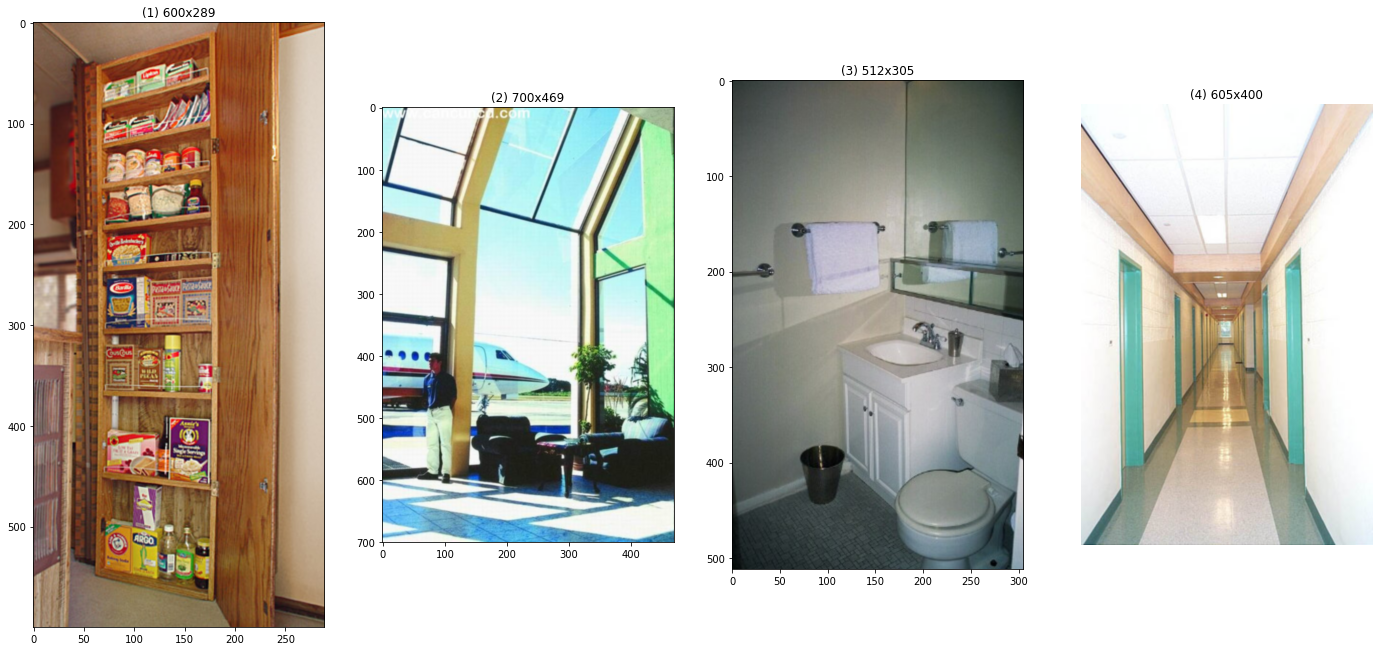

In [6]:
print(len(indoor_images_size_list))
images_size_rnd_list = random.sample(indoor_images_size_list, 4)
show_images(images_size_rnd_list)

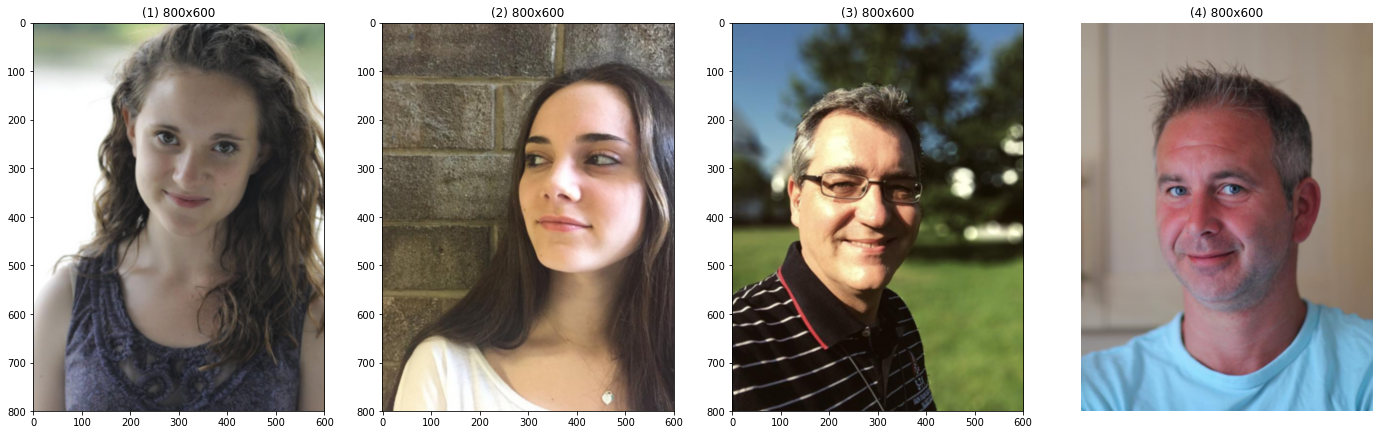

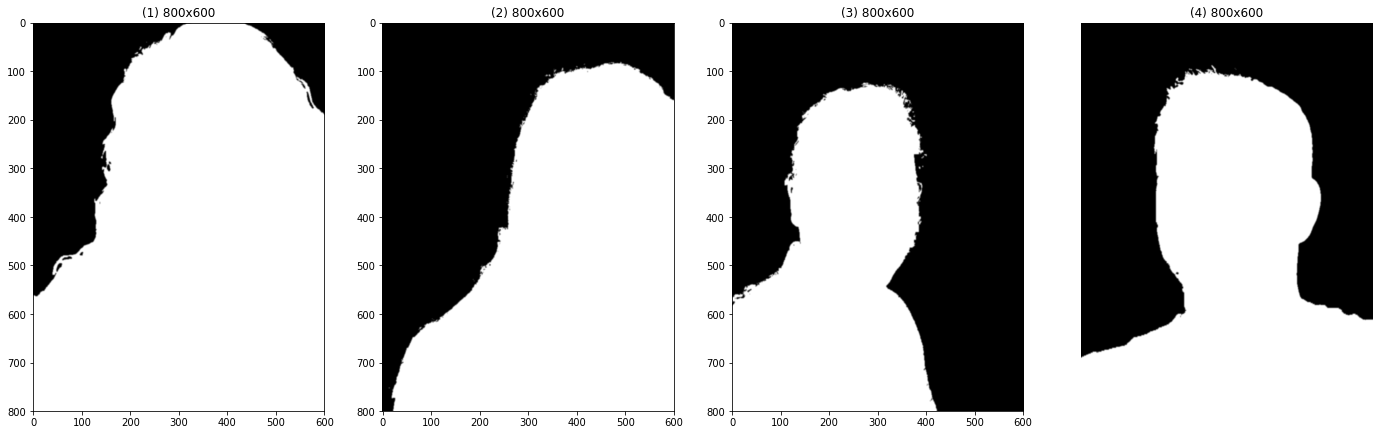

In [7]:
ORIG_IMAGE_DIR='/mnt/data/portraitfcn/eg_code_data_release_processed/data/images_data_crop'
IMAGE_DIR='/mnt/data/portraitfcn/eg_code_data_release_processed/data/images_mask_png'
orig_file_names = next(os.walk(ORIG_IMAGE_DIR))[2]
orig_image_list = random.sample(orig_file_names, 4)
orig_image_path_list = [skimage.io.imread(os.path.join(ORIG_IMAGE_DIR, x)) for x in orig_image_list]
mask_image_path_list = [skimage.io.imread(os.path.join(IMAGE_DIR, '{}.png'.format(x.split('.')[0]))) for x in orig_image_list ]
show_images(orig_image_path_list)
show_images(mask_image_path_list)

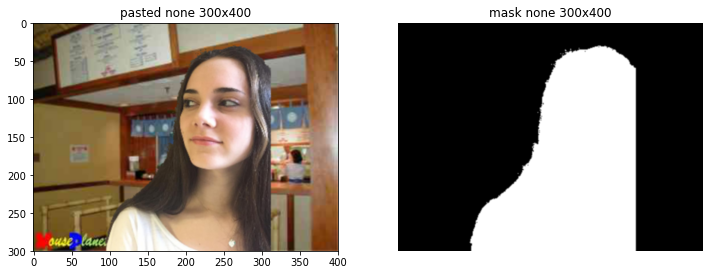

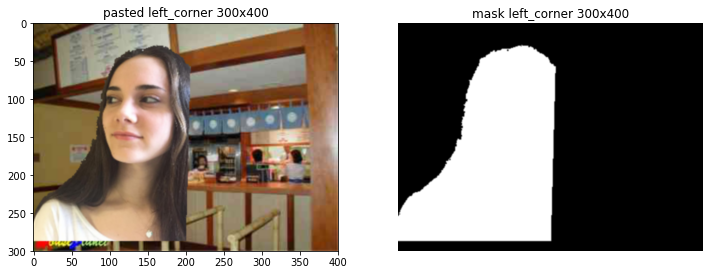

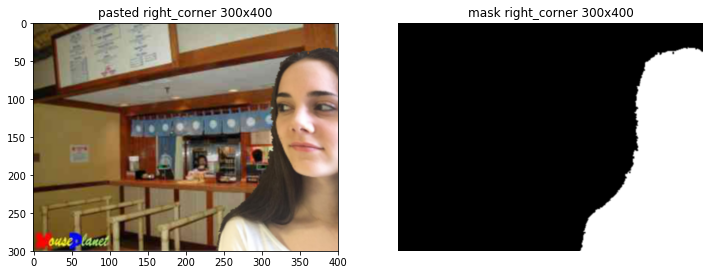

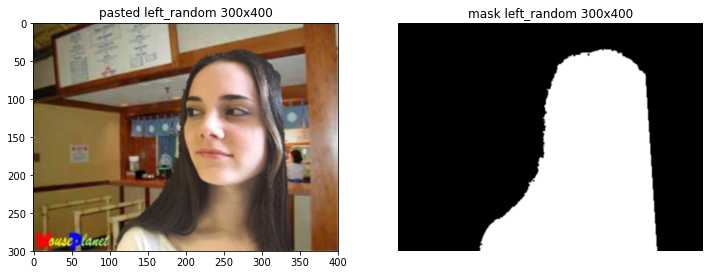

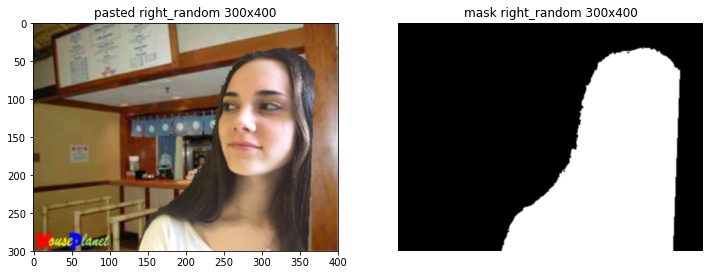

In [8]:
shift_args = ['none', 'left_corner', 'right_corner', 'left_random', 'right_random']
for a in shift_args:
    embedded_image, mask = portrait_indoor_embed(portrait_image_input=orig_image_path_list[1], 
                                                 portrait_mask_input=mask_image_path_list[1], 
                                                 indoor_image_input=rnd_indoor_images[0],
                                                 shift_arg=a, random_affine=True, intensity=1.0)
    show_images([embedded_image, mask], ["pasted {}".format(a), "mask {}".format(a)])

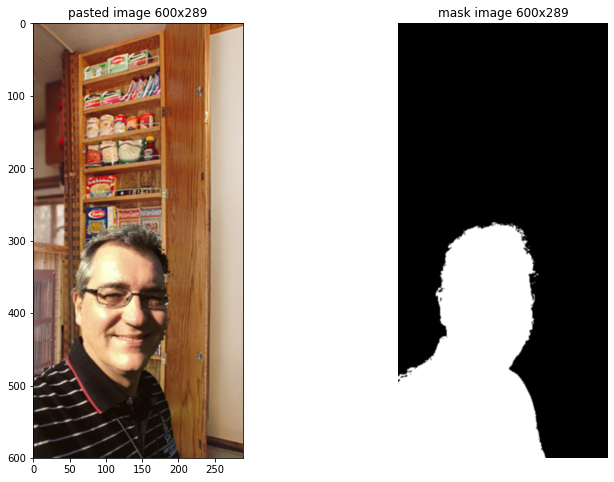

In [9]:
embedded_image_2, mask_2 =  portrait_indoor_embed(portrait_image_input=orig_image_path_list[2], 
                                              portrait_mask_input=mask_image_path_list[2], 
                                              indoor_image_input=images_size_rnd_list[0])
show_images([embedded_image_2, mask_2], ["pasted image", "mask image"])

In [ ]:
INDOOR_MRCNN_OUTPUT='/mnt/data/indoor/rcnn_output.p'
with open(os.path.abspath(INDOOR_MRCNN_OUTPUT), 'rb') as f:
    indoor_rcnn_dict = pickle.load(f)

In [ ]:
k, v = list(indoor_rcnn_dict.items())[0]

In [ ]:
print('Key: {}'.format(k))
print('Value: {}'.format(v))

In [ ]:
non_person_keys = []
person_keys = []
person_count_keys = {}
for k, v in indoor_rcnn_dict.items():
    if 'person' in v and v['person'] > 0:
        person_keys.append(k)
        person_count = int(v['person'])
        if person_count not in person_count_keys:
            person_count_keys[person_count] = [k]
        else:
            person_count_keys[person_count].append(k)
    else:
        non_person_keys.append(k)

In [ ]:
print('Number of indoor images with person: {}'.format(len(person_keys)))
print('Number of indoor images without person: {}'.format(len(non_person_keys)))

In [10]:
def _portrait_indoor_embed_from_files(portrait_image_path, portrait_mask_path, indoor_image_path,
                                      shift_arg, image_output_dir, mask_output_dir):
    
    if os.path.isfile(image_output_dir) and os.path.isfile(mask_output_dir):
        return

    portrait_image = skimage.io.imread(portrait_image_path)
    portrait_mask = skimage.io.imread(portrait_mask_path)
    indoor_image = skimage.io.imread(indoor_image_path)
    
    pasted_image, mask =  portrait_indoor_embed(portrait_image_input=portrait_image, 
                                 portrait_mask_input=portrait_mask,
                                 indoor_image_input=indoor_image, shift_arg=shift_arg,
                                 random_affine=True)
    
    if pasted_image is not None and mask is not None:
        skimage.io.imsave(image_output_dir, pasted_image)
        skimage.io.imsave(mask_output_dir, mask)

def split_indoor_data(indoor_prefix, indoor_images_dir, indoor_mrcnn_output, split_ratio=0.2, seed=42):
    """
    Equalize person and no person data from indoor and split into train and test
    """
    random.seed(seed)
    with open(os.path.abspath(
        os.path.join(indoor_prefix, indoor_mrcnn_output)), 'rb') as f:
        indoor_rcnn_dict = pickle.load(f)
    non_person_keys = []

    person_keys = []
    person_count_keys = {}
    for k, v in indoor_rcnn_dict.items():
        if 'person' in v and v['person'] > 0:
            person_keys.append(k)
            person_count = int(v['person'])
            if person_count not in person_count_keys:
                person_count_keys[person_count] = [k]
            else:
                person_count_keys[person_count].append(k)
        else:
            non_person_keys.append(k)
    
    random.shuffle(person_keys)
    random.shuffle(non_person_keys)
    if len(non_person_keys) > len(person_keys):
        non_person_keys = non_person_keys[0:len(person_keys)]
        
    persons_idx = int(len(person_keys)*(1-split_ratio))
    persons_train_list = person_keys[0:persons_idx]
    persons_test_list = person_keys[persons_idx:len(person_keys)]
    
    non_persons_idx = int(len(non_person_keys)*(1-split_ratio))
    non_persons_train_list = non_person_keys[0:non_persons_idx]
    non_persons_test_list = non_person_keys[non_persons_idx:len(non_person_keys)]
    
    return persons_train_list, persons_test_list, non_persons_train_list, non_persons_test_list
    
def process_portrait_and_indoor_images(indoor_prefix, indoor_images_dir, indoor_persons_images_list,
                                       indoor_non_persons_images_list,
                                       portrait_prefix, portrait_image_dir, portrait_mask_dir, 
                                       portrait_images_list, output_image_dir, output_mask_dir,
                                       indoor_images_per_portrait=10, 
                                       shift_args=['none', 'left_corner', 'right_corner', 
                                                   'left_random', 'right_random']):
    """
    Helper to output processed images.
    """
    
    
    process_list = [] # (portrait_image_file, portrait_image_mask_file, indoor_file, shift_arg)
    indoor_persons_idx = 0
    indoor_non_persons_idx = 0
    portrait_image_path = os.path.abspath(os.path.join(portrait_prefix, portrait_image_dir))
    portrait_mask_path = os.path.abspath(os.path.join(portrait_prefix, portrait_mask_dir))
    indoor_image_path = os.path.abspath(os.path.join(indoor_prefix, indoor_images_dir))
    for portrait_image_id in portrait_images_list:
        p_img_path = os.path.join(portrait_image_path, '{}.jpg'.format(portrait_image_id))
        p_mask_path = os.path.join(portrait_mask_path, '{}.png'.format(portrait_image_id))
        for a in shift_args:
            for j in range(0, indoor_images_per_portrait):
                indoor_image_fname = '{}_{}'.format(portrait_image_id,
                    ''.join(
                        '_'.join(indoor_persons_images_list[indoor_persons_idx].split('/')).split('.')[:-1]))
                
                i_person_img_path = os.path.join(indoor_image_path, '{}'.format(
                    indoor_persons_images_list[indoor_persons_idx]))
                process_list.append((p_img_path, p_mask_path, i_person_img_path, a,
                                    os.path.abspath(os.path.join(output_image_dir, 
                                                                 '{}.jpg'.format(indoor_image_fname))),
                                    os.path.abspath(os.path.join(output_mask_dir, 
                                                                 '{}.png'.format(indoor_image_fname)))))
     
                indoor_image_fname = '{}_{}'.format(portrait_image_id,
                    ''.join(
                        '_'.join(indoor_non_persons_images_list[indoor_non_persons_idx].
                                 split('/')).split('.')[:-1]))
                i_non_person_img_path = os.path.join(indoor_image_path, '{}'.format(
                    indoor_non_persons_images_list[indoor_non_persons_idx]))
                process_list.append((p_img_path, p_mask_path, i_non_person_img_path, a,
                                    os.path.abspath(os.path.join(output_image_dir, 
                                                                 '{}.jpg'.format(indoor_image_fname))),
                                    os.path.abspath(os.path.join(output_mask_dir, 
                                                                 '{}.png'.format(indoor_image_fname)))))
                
                indoor_persons_idx += 1
                indoor_non_persons_idx += 1
                indoor_persons_idx %= len(indoor_persons_images_list)
                indoor_non_persons_idx %= len(indoor_non_persons_images_list)
                
        
    Parallel(n_jobs=8)(delayed(_portrait_indoor_embed_from_files)(*i) for i in process_list)
    return process_list

def load_portrait_list(portrait_prefix, portrait_file):
    ret_list = []
    with open(os.path.abspath(os.path.join(portrait_prefix, portrait_file)), 'r') as f:
        line = f.readline()
        while line:
            ret_list.append(line.strip())
            line = f.readline()

    return ret_list

In [11]:
INDOOR_BASE_DIR='/mnt/data/indoor'
INDOOR_IMAGES_DIR='Images'
INDOOR_MRCNN_OUTPUT='rcnn_output.p'
PORTRAIT_BASE_DIR='/mnt/data/portraitfcn/eg_code_data_release_processed/data'
PORTRAIT_IMAGES_DIR='images_data_crop'
PORTRAIT_MASK_DIR='images_mask_png'
PORTRAIT_TRAIN_FILE='train.txt'
PORTRAIT_TEST_FILE='test.txt'
persons_train_list, persons_test_list, non_persons_train_list, non_persons_test_list = \
split_indoor_data(indoor_prefix=INDOOR_BASE_DIR, indoor_images_dir=INDOOR_IMAGES_DIR, 
                  indoor_mrcnn_output=INDOOR_MRCNN_OUTPUT)

print('Persons train len: {}'.format(len(persons_train_list)))
print('Persons test len: {}'.format(len(persons_test_list)))
print('Non Persons train len: {}'.format(len(non_persons_train_list)))
print('Non Persons test len: {}'.format(len(non_persons_test_list)))

portrait_train_images_list = load_portrait_list(portrait_prefix=PORTRAIT_BASE_DIR, portrait_file='train.txt')
portrait_test_images_list = load_portrait_list(portrait_prefix=PORTRAIT_BASE_DIR, portrait_file='val.txt')

print('Portrait train len: {}'.format(len(portrait_train_images_list)))
print('Portrait test len: {}'.format(len(portrait_test_images_list)))

process_train_list = process_portrait_and_indoor_images(
                                                  indoor_prefix=INDOOR_BASE_DIR, 
                                                  indoor_images_dir=INDOOR_IMAGES_DIR, 
                                                  indoor_persons_images_list=persons_train_list,
                                                  indoor_non_persons_images_list=non_persons_train_list,
                                                  portrait_prefix=PORTRAIT_BASE_DIR, 
                                                  portrait_image_dir=PORTRAIT_IMAGES_DIR, 
                                                  portrait_mask_dir=PORTRAIT_MASK_DIR, 
                                                  portrait_images_list=portrait_train_images_list, 
                                                  output_image_dir='/mnt/data/portrait_indoor_aug/train/images', 
                                                  output_mask_dir='/mnt/data/portrait_indoor_aug/train/mask')

process_test_list = process_portrait_and_indoor_images(
                                                  indoor_prefix=INDOOR_BASE_DIR, 
                                                  indoor_images_dir=INDOOR_IMAGES_DIR, 
                                                  indoor_persons_images_list=persons_test_list,
                                                  indoor_non_persons_images_list=non_persons_test_list,
                                                  portrait_prefix=PORTRAIT_BASE_DIR, 
                                                  portrait_image_dir=PORTRAIT_IMAGES_DIR, 
                                                  portrait_mask_dir=PORTRAIT_MASK_DIR, 
                                                  portrait_images_list=portrait_test_images_list, 
                                                  output_image_dir='/mnt/data/portrait_indoor_aug/test/images', 
                                                  output_mask_dir='/mnt/data/portrait_indoor_aug/test/mask')

Persons train len: 5275
Persons test len: 1319
Non Persons train len: 5275
Non Persons test len: 1319
Portrait train len: 1320
Portrait test len: 330


In [ ]:
print('Process train size: {}'.format(len(process_train_list)))
print('Process test size: {}'.format(len(process_test_list)))

In [ ]:
print(process_test_list[3])

## Prepare data for UNet

Convert to grayscale and also resize to 256x256x1 and keep the aspect ration

In [58]:
import glob
def prep_image_for_unet(image_path, resize=256, grayscale=True):
    if grayscale is True:
        image = np.asarray(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
    else:
        image = np.asarray(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    
    resized_image = resize_image(image, min_dim=resize, max_dim=resize,
                                 mode="square")[0]
    if grayscale is True:
        resized_image = resized_image.reshape((256, 256, 1))

    return resized_image

def process_all_images_for_unet(input_dir, output_dir, suffix='jpg', resize=256, grayscale=True):
    image_paths = glob.glob(os.path.join(input_dir, '*.{}'.format(suffix)))
    for image_path in image_paths:
        resized_image = prep_image_for_unet(image_path, resize=resize, 
                                            grayscale=grayscale)
        output_image_path = os.path.join(output_dir, os.path.basename(image_path))
        cv2.imwrite(output_image_path, resized_image)
    return len(image_paths)

In [5]:
INDOOR_AUG_TRAIN='/mnt/data/portrait_indoor_aug/train'
INDOOR_AUG_TEST='/mnt/data/portrait_indoor_aug/test'
UNET_OUTPUT_TRAIN_DIR='/mnt/data/portrait_indoor_unet/train'
UNET_OUTPUT_TEST_DIR='/mnt/data/portrait_indoor_unet/test'

In [6]:
train_images = glob.glob(os.path.join(INDOOR_AUG_TRAIN, 'images/*.jpg'))
train_masks = glob.glob(os.path.join(INDOOR_AUG_TRAIN, 'masks/*.png'))

In [30]:
test_images = glob.glob(os.path.join(INDOOR_AUG_TEST, 'images/*.jpg'))
test_masks = glob.glob(os.path.join(INDOOR_AUG_TEST, 'masks/*.png'))

In [49]:
images_to_resize = random.sample(train_images, 4)
resized_list = [prep_image_for_unet(x, grayscale=True) for x in images_to_resize]

orig shape: (400, 500), resized shape: (256, 256, 1)
orig shape: (256, 256), resized shape: (256, 256, 1)
orig shape: (338, 451), resized shape: (256, 256, 1)
orig shape: (355, 530), resized shape: (256, 256, 1)


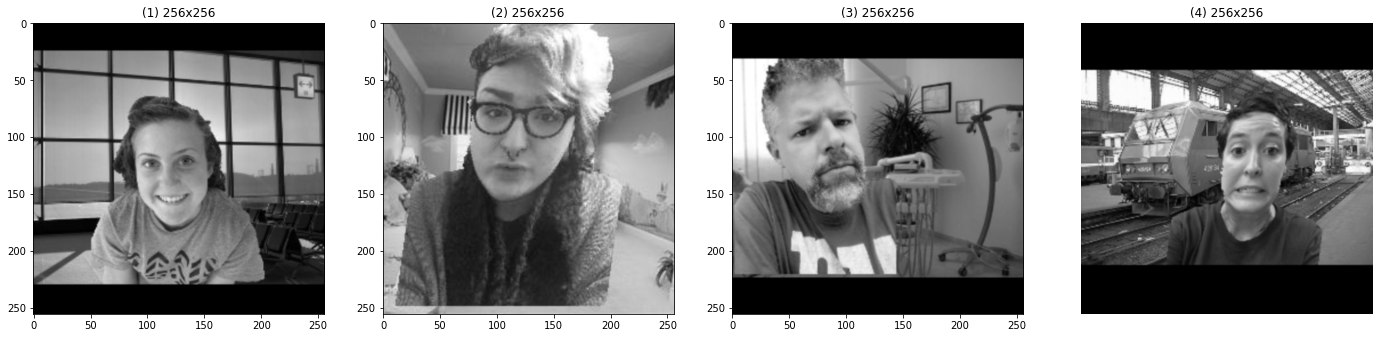

In [50]:
show_images(resized_list)

In [59]:
process_all_images_for_unet(input_dir=os.path.join(INDOOR_AUG_TEST, 'images'), 
                            output_dir=os.path.join(UNET_OUTPUT_TEST_DIR, 'images'),
                            suffix='jpg', resize=256, grayscale=True)
process_all_images_for_unet(input_dir=os.path.join(INDOOR_AUG_TEST, 'masks'), 
                            output_dir=os.path.join(UNET_OUTPUT_TEST_DIR, 'masks'),
                            suffix='png', resize=256, grayscale=True)

33000

In [60]:
unet_test_images = glob.glob(os.path.join(UNET_OUTPUT_TEST_DIR, 'images/*.jpg'))
unet_test_masks = glob.glob(os.path.join(UNET_OUTPUT_TEST_DIR, 'masks/*.png'))

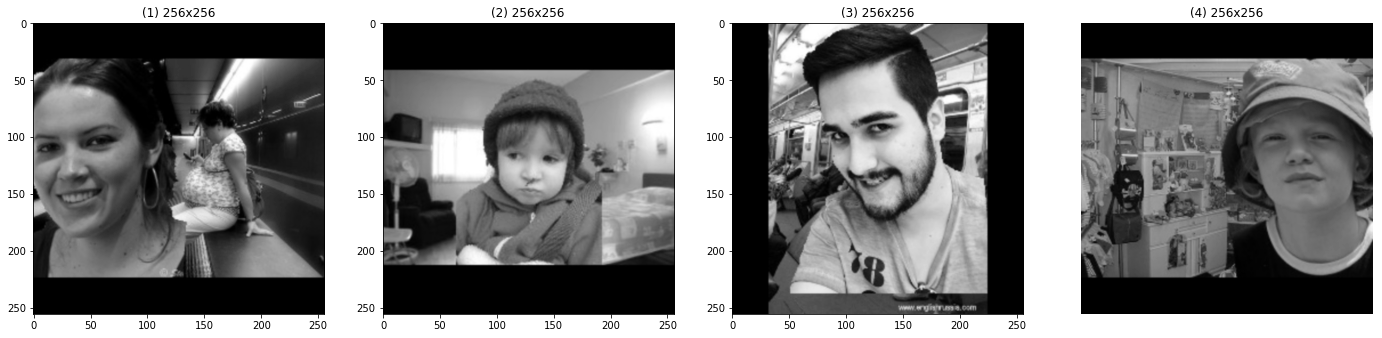

In [62]:
unet_test_images_list = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in random.sample(unet_test_images, 4)]
show_images(unet_test_images_list)

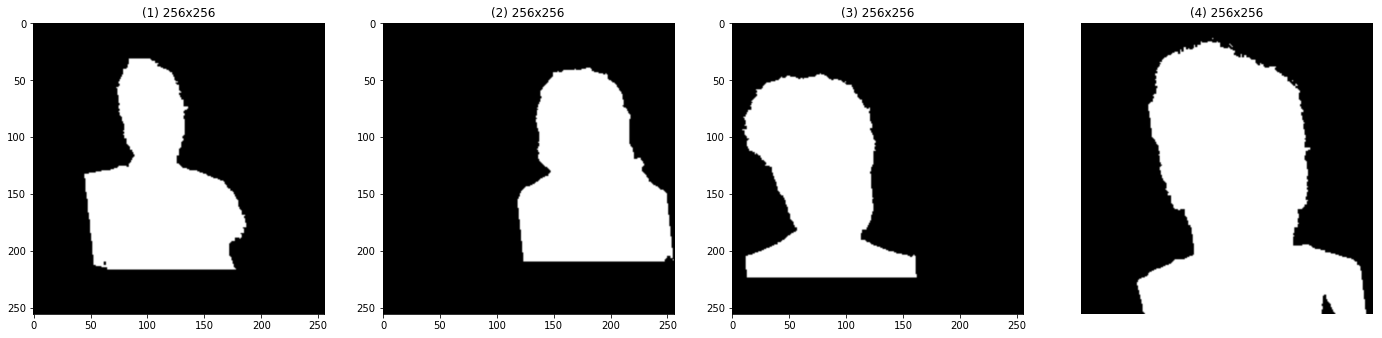

In [64]:
unet_test_masks_list = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in random.sample(unet_test_masks, 4)]
show_images(unet_test_masks_list)

In [65]:
process_all_images_for_unet(input_dir=os.path.join(INDOOR_AUG_TRAIN, 'images'), 
                            output_dir=os.path.join(UNET_OUTPUT_TRAIN_DIR, 'images'),
                            suffix='jpg', resize=256, grayscale=True)
process_all_images_for_unet(input_dir=os.path.join(INDOOR_AUG_TRAIN, 'masks'), 
                            output_dir=os.path.join(UNET_OUTPUT_TRAIN_DIR, 'masks'),
                            suffix='png', resize=256, grayscale=True)

131900

In [24]:
aug_list = random.sample(train_images, 4)

In [25]:
mask_list = [os.path.join(INDOOR_AUG_TRAIN, 'masks/{}.png'.format(os.path.basename(x).split('.')[0])) for x in aug_list]

In [28]:
aug_images = [cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB) for x in aug_list]
mask_images = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in mask_list]

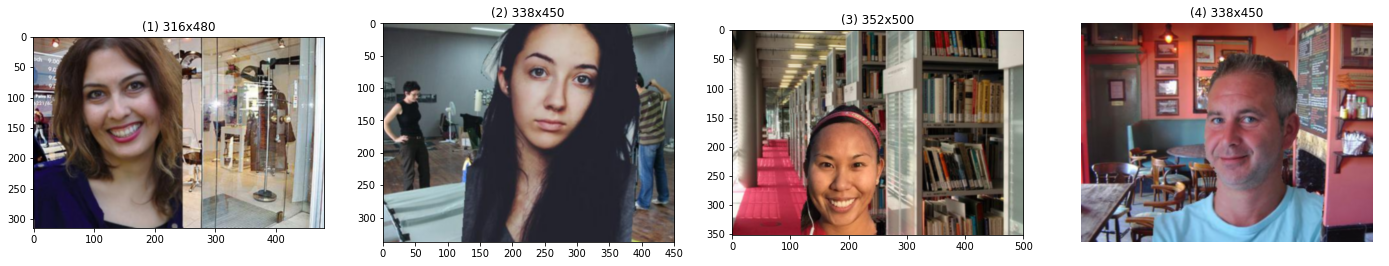

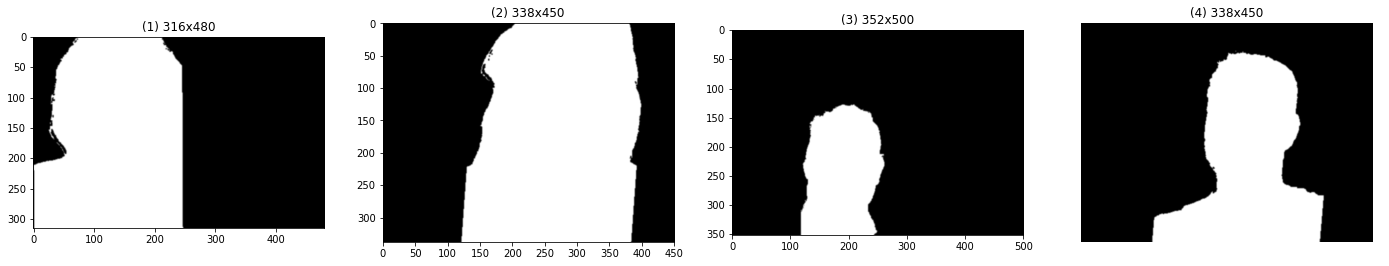

In [29]:
show_images(aug_images)
show_images(mask_images)